In [0]:
!apt-get install -y xvfb python-opengl x11-utils > /dev/null 2>&1
!pip install gym pyvirtualdisplay scikit-video > /dev/null 2>&1

%tensorflow_version 2.x
import tensorflow as tf

import numpy as np
import base64, io, time, gym
import IPython, functools
import matplotlib.pyplot as plt
from tqdm import tqdm

!pip install mitdeeplearning
import mitdeeplearning as mdl

     |████████████████████████████████| 2.1MB 3.4MB/s 
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.1.2-cp36-none-any.whl size=2114586 sha256=4fe7b8882ce6ff7631b277c4f8996ba8ce806f7301fbfd49a0b7e046dbed3e54
  Stored in directory: /root/.cache/pip/wheels/27/e1/73/5f01c787621d8a3c857f59876c79e304b9b64db9ff5bd61b74
Successfully built mitdeeplearning


In [0]:
env = gym.make("SpaceInvaders-v0")
env.seed(1)

[1, 289714752]

In [0]:
n_observations = env.observation_space
print("Environment has observation space =", n_observations)

Environment has observation space = Box(210, 160, 3)


In [0]:
n_actions = env.action_space.n
print("Number of possible actions that the agent can choose from =", n_actions)

Number of possible actions that the agent can choose from = 6


In [0]:
rewards=env.reward_range
print("rewards: ",rewards)

rewards:  (-inf, inf)


In [0]:
observation = env.reset()

next_observation, reward, done, info = env.step(0)
  #print("obs: ",next_observation)
print("reward: ",reward)
print("done: ",done)
print("infor: ",info)

reward:  0.0
done:  False
infor:  {'ale.lives': 3}


In [0]:
import gym
env = gym.make('SpaceInvaders-v0')
for i_episode in range(20):
    observation = env.reset()
    for t in range(100):
        #env.render()
        #print(observation)
        action = env.action_space.sample()
        print("Action is: ",action)
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

In [0]:
Conv2D=functools.partial(tf.keras.layers.Conv2D,padding="same",activation="relu")
Flatten=tf.keras.layers.Flatten
Dense=tf.keras.layers.Dense

def create_spaceInvaders_model():
  model = tf.keras.models.Sequential([
          Conv2D(filters=16,kernel_size=7,strides=4),
          Conv2D(filters=32,kernel_size=5,strides=2),
          Conv2D(filters=48,kernel_size=3,strides=2),
          Flatten(),
          Dense(units=64,activation="relu"),
          Dense(n_actions,activation=None) 
  ])
  return model
SpaceInvadersModel=create_spaceInvaders_model()

In [0]:
def normalize(x):
  x -= np.mean(x)
  x /= np.std(x)
  return x.astype(np.float32)

In [0]:
def discount_rewards(rewards, gamma=0.99): 
  discounted_rewards = np.zeros_like(rewards)
  R = 0
  for t in reversed(range(0, len(rewards))):
      # NEW: Reset the sum if the reward is not 0 (the game has ended!)
      if rewards[t] != 0:
        R = 0
      # update the total discounted reward as before
      R = R * gamma + rewards[t]
      discounted_rewards[t] = R
      
  return normalize(discounted_rewards)

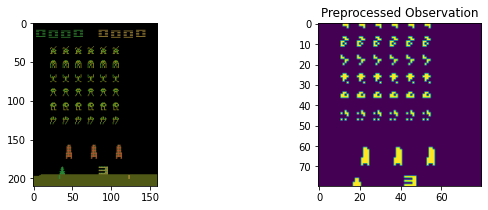

In [0]:
observation = env.reset()
for i in range(30):
  observation, _,_,_ = env.step(0)
observation_pp = mdl.lab3.preprocess_pong(observation)

f = plt.figure(figsize=(10,3))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.imshow(observation); ax.grid(False);
ax2.imshow(np.squeeze(observation_pp)); ax2.grid(False); plt.title('Preprocessed Observation');

In [0]:
class Memory:
  def __init__(self):
    self.clear()
  
  def clear(self):
    self.observations=[]
    self.rewards=[]
    self.actions=[]

  def add_to_memory(self,new_observation,new_action,new_rewards):
    self.observations.append(new_observation)
    self.rewards.append(new_rewards)
    self.actions.append(new_action)

memory=Memory()
  

In [0]:
def choose_action(model, observation):
  # add batch dimension to the observation
  observation = np.expand_dims(observation, axis=0)

  logits = model.predict(observation) 
  prob_weights = tf.nn.softmax(logits).numpy()
  
  action = np.random.choice(n_actions, size=1, p=prob_weights.flatten())[0] # TODO
  
  return action

In [0]:
def compute_loss(logits,actions,rewards):
  neg_logprob=tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,labels=actions)
  loss=tf.reduce_mean(neg_logprob * rewards)
  return loss

In [0]:
def train_step(model,optimizer,observations,actions,discount_rewards):
  with tf.GradientTape() as Tape:
    logits=model(observations)
    loss=compute_loss(logits,actions,discount_rewards)

  grads=Tape.gradient(loss,model.trainable_variables)
  optimizer.apply_gradients(zip(grads,model.trainable_variables))



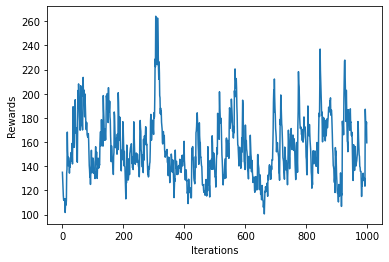

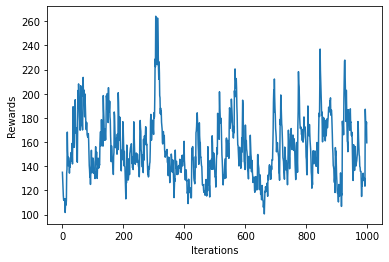

In [0]:
learning_rate=1e-4
MAX_ITERS=1000
space_model=create_spaceInvaders_model()

optimizer=tf.keras.optimizers.Adam(learning_rate)

smoothed_reward=mdl.util.LossHistory(smoothing_factor=0.9)
plotter=mdl.util.PeriodicPlotter(sec=10,xlabel="Iterations",ylabel="Rewards")

memory=Memory()

for i_episode in range(MAX_ITERS):
  
  plotter.plot(smoothed_reward.get())

  observation=env.reset()
  previous_frame=mdl.lab3.preprocess_pong(observation)
  #previous_frame=np.reshape(previous_frame,(128,128))
  #print("previous_frame",previous_frame.shape)
  

  while True:
    #current_frame=rgb2gray(observation)
    current_frame=mdl.lab3.preprocess_pong(observation)
    #print("current_frame",curr_frame.shape)
    obs_change=current_frame - previous_frame
    action=choose_action(space_model,obs_change)

    next_observation,reward,done,info=env.step(action)

    memory.add_to_memory(obs_change,action,reward)

    if done:
      total_rewards=sum(memory.rewards)
      smoothed_reward.append(total_rewards)

      train_step(space_model,optimizer,observations=np.stack(memory.observations,0),actions=np.array(memory.actions),discount_rewards=discount_rewards(memory.rewards))
      memory.clear()
      break
    
    observation=next_observation
    previous_frame=current_frame


In [0]:
saved_pong = mdl.lab3.save_video_of_model(
    space_model, "SpaceInvaders-v0", obs_diff=True, 
    pp_fn=mdl.lab3.preprocess_pong)
mdl.lab3.play_video(saved_pong)

Successfully saved 708 frames into SpaceInvaders-v0.mp4!
